# Import des Data

On importe toutes les bibliothèques.

In [1]:
import pandas            as pd
import numpy             as np
import seaborn           as sns
import matplotlib.pyplot as plt
import spacy
import re
import sklearn
import random
import textdistance

from spacy.vocab               import Vocab
from spacy.language            import Language
from spacy.tokens              import Token
from spacymoji                 import Emoji
from   sklearn.tree            import DecisionTreeClassifier
from   sklearn.model_selection import train_test_split
from   sklearn.metrics         import confusion_matrix






Importation du corpus.

In [2]:
corpus = pd.read_csv("C:/Users/a.tekiouk/Sujet_2/Sujet_2/DATA/chanel10k.csv", sep=";", parse_dates=["publication_time"])

# on récupére les posts en anglais
mask = corpus["language"] == 'en'
corpus = corpus.loc[mask]
chanel = corpus['text'].tolist()
publication_time_chanel = corpus['publication_time'].tolist()

print(f"# documents in corpus: {len(chanel)}")

# documents in corpus: 1802


On définit les différents éléments de la *pipeline* `spacy` pour détecter les emojis et les hashtags.

In [3]:
@Language.component("hashtag")
def hashtag_pipe(
    doc : spacy.tokens.doc.Doc
) -> spacy.tokens.doc.Doc:
    """
    Spacy pipeline component that detects if a word is a hashtag or not.

    Parameters
    ----------
    doc : spacy.tokens.Doc
        The input document to process.

    Returns
    -------
    spacy.tokens.Doc
        The processed document with updated token attributes.
    """
    merged_hashtag = False
    while True:
        for token in doc:
            if token.text == '#':
                if token.head is not None:
                    start_index = token.i
                    end_index = start_index + 1
                    with doc.retokenize() as retokenizer:
                        retokenizer.merge(doc[start_index:end_index+1])
                        merged_hashtag = True
                        break
        if not merged_hashtag:
            break
        merged_hashtag = False
    return doc

# définition du pipe
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe("emoji", first=True)
nlp.add_pipe("hashtag", first=True)
Token.set_extension("is_hashtag", getter=lambda token: token.text[0] in ("#"), force=True)

# Creation d'un sample de validation

In [5]:
import utilities

In [9]:
chanel_junk_valid = corpus[['text','publication_time']].sample(n=700, random_state = 42)

In [10]:
dist = textdistance.levenshtein.normalized_distance
chanel_junk_valid_dd = utilities.delete_duplicates(chanel_junk_valid['text'].tolist(),chanel_junk_valid['publication_time'].tolist(),0.6,dist)

In [11]:
len(chanel_junk_valid_dd)

390

In [12]:
chanel_junk_valid_df= pd.DataFrame()
chanel_junk_valid_df['text'] = chanel_junk_valid_dd

In [13]:
chanel_junk_valid_df.to_csv("C:/Users/a.tekiouk/Sujet_2/Sujet_2/DATA/chanel_junk_valid.csv")
# Ajout de la variable is_junk sur excel

### Sample de validation : 

In [5]:
chanel_junk_valid_new = pd.read_excel('C:/Users/a.tekiouk/Sujet_2/Sujet_2/DATA/chanel_junk_valid_new.xlsx')
chanel_junk_valid_new = chanel_junk_valid_new[['text','is_junk']]
utilities.clear_trailing_hash(chanel_junk_valid_new['text'])

C:\Users\a.tekiouk\Sujet_2\Sujet_2\Notebooks\utilities.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [6]:
chanel_junk_valid_new.head()

,text,is_junk
0,The camelia - a long time symbol of Chanel and...,0
1,Wknds are my happy place 🤍 even if they do inc...,1
2,Used Card holder XL 24999.-\n\nLine: 244xfzmn,1
3,My love for a chanelofficial classic flap 😌| #...,0
4,HAPPY BIRTHDAY KING KUMA\n\nJENNIE #SOLO STAGE...,1


# Ajout de features

### Ratio de mot

In [7]:
chanel_junk_valid_new['word_ratio'] = utilities.get_word_ratio(corpus= chanel_junk_valid_new['text'], nlp= nlp  )

In [7]:
chanel_junk_valid_new.head()

,text,is_junk,word_ratio,caps_ratio
0,The camelia - a long time symbol of Chanel and...,0,0.587302,0.027027
1,Wknds are my happy place 🤍 even if they do inc...,1,0.680851,0.000000
2,Used Card holder XL 24999.-\n\nLine: 244xfzmn,1,1.000000,0.111111
3,My love for a chanelofficial classic flap 😌| #...,0,0.562500,0.000000
4,HAPPY BIRTHDAY KING KUMA\n\nJENNIE #SOLO STAGE...,1,0.310345,0.545455


### Ratio de caps

In [8]:
chanel_junk_valid_new['caps_ratio'] = utilities.get_caps_ratio(corpus= chanel_junk_valid_new['text'], nlp= nlp)

In [11]:
chanel_junk_valid_new.head()

,text,is_junk,word_ratio,caps_ratio,norm_punct
0,The camelia - a long time symbol of Chanel and...,0,0.587302,0.027027,0.135135
1,Wknds are my happy place 🤍 even if they do inc...,1,0.680851,0.000000,0.375000
2,Used Card holder XL 24999.-\n\nLine: 244xfzmn,1,1.000000,0.111111,0.111111
3,My love for a chanelofficial classic flap 😌| #...,0,0.562500,0.000000,0.000000
4,HAPPY BIRTHDAY KING KUMA\n\nJENNIE #SOLO STAGE...,1,0.310345,0.545455,0.000000


# Nb de ponctuation

In [9]:
chanel_junk_valid_new['norm_punct'] = utilities.get_normalized_nb_punct(corpus= chanel_junk_valid_new['text'], nlp= nlp  )

In [10]:
chanel_junk_valid_new.head()

,text,is_junk,word_ratio,caps_ratio,norm_punct
0,The camelia - a long time symbol of Chanel and...,0,0.587302,0.027027,0.135135
1,Wknds are my happy place 🤍 even if they do inc...,1,0.680851,0.000000,0.375000
2,Used Card holder XL 24999.-\n\nLine: 244xfzmn,1,1.000000,0.111111,0.111111
3,My love for a chanelofficial classic flap 😌| #...,0,0.562500,0.000000,0.000000
4,HAPPY BIRTHDAY KING KUMA\n\nJENNIE #SOLO STAGE...,1,0.310345,0.545455,0.000000


### Top hashtags junk

In [11]:
s = chanel_junk_valid_new[chanel_junk_valid_new['is_junk']==1]['text']

In [13]:
utilities.top_hashtags(s,nlp = nlp)

#chanel         91
#fashion        29
#style          19
#ootd           15
#explorepage    15
dtype: int64

### Top emojis junk

In [14]:
utilities.top_emojis(s,nlp=nlp)

➖    34
▪    28
🌼    20
✨    16
😍    14
dtype: int64

# Hashtag/emojis dummy

In [12]:
help(utilities.create_dummies)

Help on function create_dummies in module utilities:

create_dummies(corpus: pandas.core.series.Series, y: pandas.core.series.Series, element: str, nlp: spacy.lang.en.English, top: int = 5) -> pandas.core.frame.DataFrame
    Create dummy encodings for most frequents text elements in the given corpus.
    
    Parameters
    ----------
    corpus : pd.Series
        The corpus on which the elements will be searched for.
    y : pd.Series
        The variable which will enable to filter the rows to use to determine the top elements+
    element : str, {'hashtag', 'emoji'}
        The text element to look for. Currently, only 'hashtag' and 'emoji' are supported.
    nlp : spacy.lang.en.English
        A spacy language model with a custom pipe to detect hashtags and emojis.
    top : int, optional
        The number of top modalities to dummy encode. Default is 5.
    
    Returns
    -------
    pd.DataFrame
        The dummy encoding corresponding to the most frequent modalities of the s

In [13]:
chanel_junk_valid_new = chanel_junk_valid_new.join(utilities.create_dummies(corpus= chanel_junk_valid_new['text'],y = chanel_junk_valid_new['is_junk'], element= 'emoji',nlp = nlp, top= 3))
chanel_all_features = chanel_junk_valid_new.join(utilities.create_dummies(corpus= chanel_junk_valid_new['text'],y = chanel_junk_valid_new['is_junk'], element= 'hashtag', nlp = nlp, top= 3))

In [14]:
chanel_all_features.head()

,text,is_junk,word_ratio,caps_ratio,norm_punct,➖,▪,🌼,#chanel,#fashion,#style
0,The camelia - a long time symbol of Chanel and...,0,0.587302,0.027027,0.135135,0,0,0,1,0,0
1,Wknds are my happy place 🤍 even if they do inc...,1,0.680851,0.000000,0.375000,0,0,0,1,1,1
2,Used Card holder XL 24999.-\n\nLine: 244xfzmn,1,1.000000,0.111111,0.111111,0,0,0,0,0,0
3,My love for a chanelofficial classic flap 😌| #...,0,0.562500,0.000000,0.000000,0,0,0,1,0,0
4,HAPPY BIRTHDAY KING KUMA\n\nJENNIE #SOLO STAGE...,1,0.310345,0.545455,0.000000,0,0,0,0,0,0


# Correlation, boxplot

C:\Users\a.tekiouk\AppData\Local\Temp\ipykernel_32184\1709041263.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_df = chanel_all_features.corr(method='pearson')
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 10134 (\N{HEAVY MINUS SIGN}) missing from current font.
  fig.canvas.draw()
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 127804 (\N{BLOSSOM}) missing from current font.
  fig.canvas.draw()
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 10134 (\N{HEAVY MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Pyth

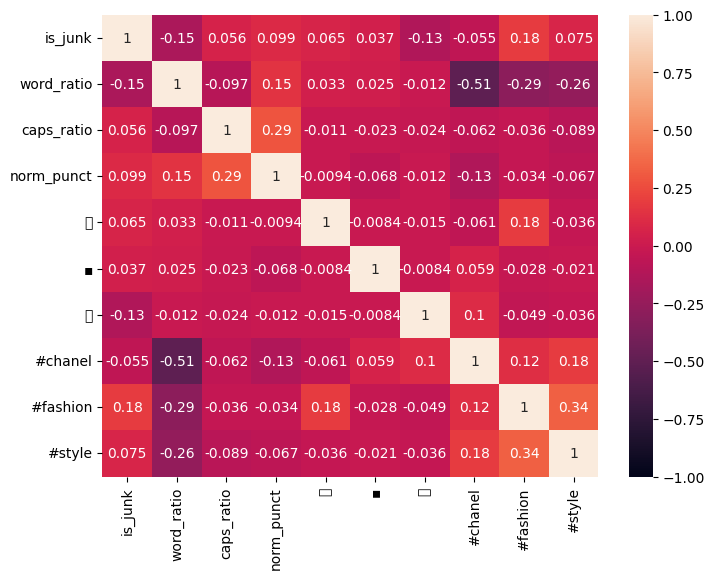

In [15]:
corr_df = chanel_all_features.corr(method='pearson')

plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True, vmin=-1, vmax=1)
plt.show()

Boxplot word ratio 

<Axes: xlabel='is_junk', ylabel='word_ratio'>

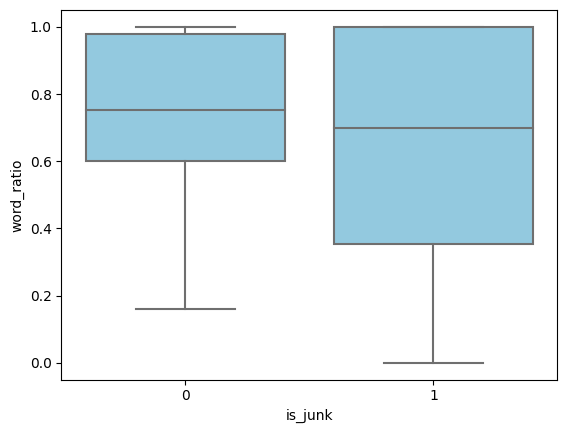

In [16]:
sns.boxplot(data  = chanel_all_features, 
            x     = "is_junk", 
            y     = "word_ratio",
            color = "skyblue")

Boxplot caps ratio

<Axes: xlabel='is_junk', ylabel='caps_ratio'>

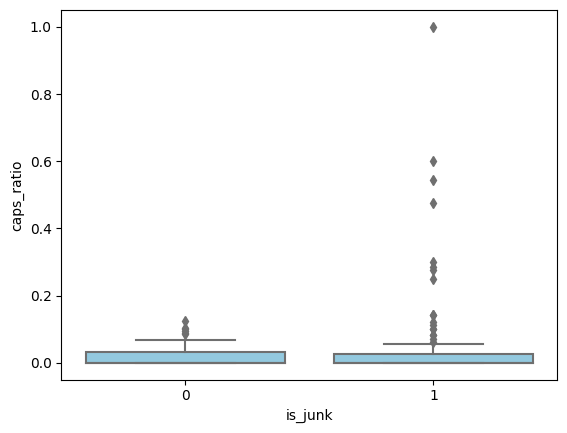

In [17]:
sns.boxplot(data  = chanel_all_features,
            x     = "is_junk",
            y     = "caps_ratio",
            color = 'skyblue')

Boxplot nb ponctuation

<Axes: xlabel='is_junk', ylabel='norm_punct'>

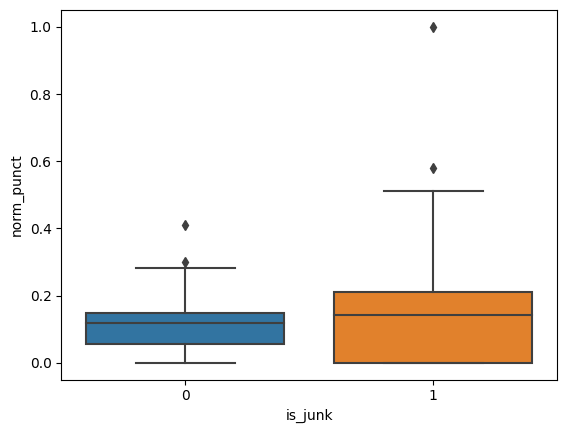

In [55]:
sns.boxplot(data = chanel_all_features,
            x    = "is_junk",
            y    = "norm_punct" )

# Arbre de decision

In [18]:
train,test = utilities.train_test(data = chanel_all_features.drop('text',axis=1), y = 'is_junk', f_y0= 0.75, f_y1= 0.40)

In [19]:
tree1 = DecisionTreeClassifier()

In [20]:
X_train = train.drop('is_junk',axis=1)
y_train = train['is_junk']
X_test = test.drop('is_junk',axis=1)
y_test = test['is_junk']

In [21]:
tree1.fit(X_train,y_train)

DecisionTreeClassifier()

[Text(0.39545454545454545, 0.9666666666666667, 'x[0] <= 0.517\ngini = 0.453\nsamples = 98\nvalue = [34, 64]'),
 Text(0.18181818181818182, 0.9, 'x[0] <= 0.399\ngini = 0.142\nsamples = 26\nvalue = [2, 24]'),
 Text(0.10909090909090909, 0.8333333333333334, 'x[0] <= 0.163\ngini = 0.091\nsamples = 21\nvalue = [1, 20]'),
 Text(0.07272727272727272, 0.7666666666666667, 'x[0] <= 0.151\ngini = 0.219\nsamples = 8\nvalue = [1, 7]'),
 Text(0.03636363636363636, 0.7, 'gini = 0.0\nsamples = 7\nvalue = [0, 7]'),
 Text(0.10909090909090909, 0.7, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.14545454545454545, 0.7666666666666667, 'gini = 0.0\nsamples = 13\nvalue = [0, 13]'),
 Text(0.2545454545454545, 0.8333333333333334, 'x[0] <= 0.423\ngini = 0.32\nsamples = 5\nvalue = [1, 4]'),
 Text(0.21818181818181817, 0.7666666666666667, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.2909090909090909, 0.7666666666666667, 'gini = 0.0\nsamples = 4\nvalue = [0, 4]'),
 Text(0.6090909090909091, 0.9, 'x[2] <= 0.13

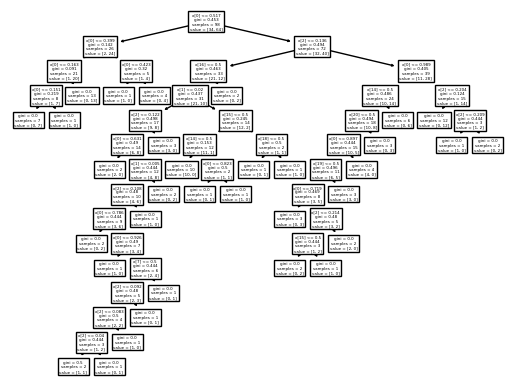

In [24]:
sklearn.tree.plot_tree(tree1)

In [23]:
pred = tree1.predict(X_test)

In [24]:
cm = confusion_matrix(y_true = y_test, y_pred = pred)

print(f"TP : {cm[0,0]}  | FP : {cm[0,1]}\nFN : {cm[1,0]} | TN : {cm[1,1]}")

TP : 4  | FP : 8
FN : 29 | TN : 68
